---
# NOTEBOOK 2 - FIRST-ROUND DATA PROCESSING & CLEANING
---

# Project 3:
# 'Wait, was that a joke?' - Language Model Identification of Absurdist Humor and Satire
## Daniel Rossetti

# Problem Statement:
This project is conducted from the standpoint of a data scientist hired by a university researching the relatability of AI chat bots and their ability to identify nuances of human language, particularly humor.  Some statements are considered funny, but are not necessarily presented as a joke.  The task is to come up with a language model that can identify humorous strings of text which are not structed in the format of a joke but are of similar structure to factual information.  Text must sourced to train and test a model which can differentiate between humorous and non-humorous statements.

**Can an NLP model be trained to recognize satire or absurdist humor?**

# Project Approach:
The Onion is a satirical news organization which produces news titles and news stories often relevant to real, current events that are satirical or would otherwise be classified as absurdist humor.  For clarity **news articles and titles from The Onion are not real.**  The tiles are however, formated in the format of actual news titles and articles which, from legitimate news agencies - are not humorous.

Comparing the titles of posts to the subreddit r/TheOnion against the subreddit r/worldnews provides a way to compare strings of text which share many of the same formatting characteristics, but have completely different goals with respect to humor.

These subreddits are to be scraped and the data processed to see if a language model can idenifty the humorous Onion titles from the factual World News titles.

# Data Cleaning and Pre-Processing Approach
In this notebook the news titles from both subreddits are explored and cleaned.  Ideally, when making this comparison, as little processing would be done as possible.  However, as will be shown below, the data collected suffer from a few issues:
* Not all of the titles sourced through the 'pushshift' API are legitimate Onion or World News posts given that users are allowed to contribute what they want, and the pushshift API sources the information before the subreddit moderators are able to remove illegitimate news titles
* Not all of the titles sourced are in English, which if not removed, would make a language model far more difficult to train
* The data contain character errors 
* The titles contain information that would directly indidcate which subreddit the title is from

With this, the data cleaning and pre-processing was broken down into two stages:
* A first stage - **ocurring in a previous notebook** - where only issues that would severly affect the model performance were removed such as bad characters, different languages
    * After this, a few models were run to ensure that the models were capable of running on the collected data, and to baseline their performance on minimally processed data.  The hope in doing this was to uncover any issues that would prevent the word vectorizing or modeling methods from working prpoperly so that they could be identified early.
* **A second stage of processing was performed in this notebook** and focused on isolating the true title text as much as possible and removing any identifiers in the titles that the model could be trained to recognize to immediately classify the model without considering the rest of its content.  

Again, the goal is to process the titles in such a way that the true news article title content is isolated for comparison (as best as possible without manually examining and cleaning each title).

# Train-Test-Splits, Model Retraining, Data Leakage Concerns, and Hold-Out Datasets

In this notebook and the previous notebook, ALL data are processed BEFORE the train-test-split occurs.  The data are processed, and a models are run in between pre-processing stages to be retrained after the second stage of processing.

This presents a concern for data leakage.  However, as the ultimate goal of this task is to focus on the conent in the subreddit posts which are the ACTUAL titles of the news articles (and not the names of the news agencies, emjois, etc.), it will be argued that processing all data simultaneously (including those which will end up in the test dataset) is acceptable as long as the processing/cleaning only serves to isolate the true title content.  On the other hand, viewing titles that would end up in the test dataset and creating features which would specifically identify humor would not be acceptable and will be avoided.

Put differntly, this task is going beyond the subreddit designation and is focusing on humor.  Part of the challenge is to make this less about differntiating between subreddits and more about truly comapable pure news article titles.  Thus, viewing data that end up being in the test dataset for the purpose stripping away features which ONLY serve to idenify the reddit and have notthing to do with the news article title should be fair game for removal.

With all of that being established, a hold-out dataset will be collected and run against the final model to further validate model performance.



# CONTENT WARNING - INAPPROPRIATE LANGUAGE
The folowing should be noted before continuing with this notebook:
* The subreddit posts collected (and therefore shown or presented in these notebooks) may contian profanity or vulgarities, or be otherwise NSFW (Not Safe for Work) due to the fact that the posts are collected before the subreddit mderators can remove them, and that The Onion commonly uses this language for the sake of humor
* The subreddit posts were not generated by the author of this project/notebooks and do not represent his opinions


# 0 - Import Packages & Read-in Previously Collected Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html


# Language Detection Imports:
# SOURCE:  https://spacy.io/
# SOURCE:  https://pypi.org/project/spacy-langdetect/
import spacy
from spacy_langdetect import LanguageDetector
from spacy.language import Language

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
onion = pd.read_csv('../data/theonion_1682378516.csv')
wldnws = pd.read_csv('../data/worldnews_1682378600.csv')
print(onion.shape), print(wldnws.shape)

(5996, 100)
(5990, 94)


(None, None)

In [3]:
# Select only the columns that would be needed going forward.
#  Some of these may be dropped later but may make it easier to clean the data for now
onion = onion[['subreddit', 'selftext', 'title', 'subreddit_name_prefixed', 'whitelist_status', 'created_utc']]
wldnws = wldnws[['subreddit', 'selftext', 'title', 'subreddit_name_prefixed', 'whitelist_status', 'created_utc']]
onion.shape, wldnws.shape

((5996, 6), (5990, 6))

In [4]:
onion.head()

,subreddit,selftext,title,subreddit_name_prefixed,whitelist_status,created_utc
0,TheOnion,NaN,Idiot Tornado Tears Harmlessly Through Empty F...,r/TheOnion,all_ads,1682364316
1,TheOnion,NaN,New Texas Law Requires Schools To Display Imag...,r/TheOnion,all_ads,1682363827
2,TheOnion,NaN,New Poll Finds Americans Would Respect Biden M...,r/TheOnion,all_ads,1682361260
3,TheOnion,NaN,Could You Pass Racial Discrimination Training ...,r/TheOnion,all_ads,1682337233
4,TheOnion,NaN,Dog And Owner Having Public Fight,r/TheOnion,all_ads,1682337233


In [5]:
wldnws.head()

,subreddit,selftext,title,subreddit_name_prefixed,whitelist_status,created_utc
0,worldnews,NaN,The parents of a 10-year-old boy living with a...,r/worldnews,all_ads,1682378366
1,worldnews,NaN,The parents of a 10-year-old boy living with a...,r/worldnews,all_ads,1682378299
2,worldnews,NaN,Mexico finds tons of liquid meth in tequila bo...,r/worldnews,all_ads,1682377256
3,worldnews,NaN,"Tucker Carlson Leaving Fox News, Last Episode ...",r/worldnews,all_ads,1682377118
4,worldnews,NaN,Film explores B.C. woman’s experience with mag...,r/worldnews,all_ads,1682376664


# 1 - Drop Duplicates and Remove Unneeded Columns

---
# 1.1 - Check for Duplicates

### 1.1.1 - Check for Duplicate Rows

In [6]:
onion.drop_duplicates().shape, wldnws.drop_duplicates().shape

((5995, 6), (5990, 6))

Both dataframes have a comparable number of samples to start off with

In [7]:
onion['title'].shape, onion['title'].drop_duplicates().shape

((5996,), (5478,))

In [8]:
wldnws['title'].shape, wldnws['title'].drop_duplicates().shape

((5990,), (5413,))

Looking at the 'title' however, it can be seen that there are duplicate titles.  It may be intersting to investigate these further.

### 1.1.2 - Check for Duplicate Titles

In [9]:
# Filter only values where the title is duplicated.
#  Set 'keep' = False to keep all instances so we can see how they are duplicated
#   Source:  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
onion[onion['title'].duplicated(keep = False) == True].sort_values('title').head(20)

,subreddit,selftext,title,subreddit_name_prefixed,whitelist_status,created_utc
3147,TheOnion,NaN,109 Details About ‘Grand Theft Auto VI’ We’re ...,r/TheOnion,all_ads,1625354899
3155,TheOnion,NaN,109 Details About ‘Grand Theft Auto VI’ We’re ...,r/TheOnion,all_ads,1625157320
3277,TheOnion,NaN,5 Things To Know About ‘Friends: The Reunion’,NaN,all_ads,1621956697
3262,TheOnion,NaN,5 Things To Know About ‘Friends: The Reunion’,NaN,all_ads,1622042399
3774,TheOnion,NaN,A Quick And Simple Drywall Recipe That Kids Wi...,NaN,all_ads,1612126697
2742,TheOnion,NaN,A Quick And Simple Drywall Recipe That Kids Wi...,r/TheOnion,all_ads,1635622335
5720,TheOnion,NaN,A Shocking Scene of Rebellion | The Onion Pres...,r/TheOnion,all_ads,1581115634
5718,TheOnion,NaN,A Shocking Scene of Rebellion | The Onion Pres...,r/TheOnion,all_ads,1581117436
4013,TheOnion,[deleted],A shocking new study that asked teen boys abou...,NaN,all_ads,1606664921
4012,TheOnion,NaN,A shocking new study that asked teen boys abou...,NaN,all_ads,1606664967


In [10]:
# Filter only values where the title is duplicated.
#  Set 'keep' = False to keep all instances so we can see how they are duplicated
#   Source:  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
wldnws[wldnws['title'].duplicated(keep = False) == True].sort_values('title').head(20)

,subreddit,selftext,title,subreddit_name_prefixed,whitelist_status,created_utc
396,worldnews,NaN,"""Caminando en mis zapatos, el mundo se ve dife...",r/worldnews,all_ads,1682264788
397,worldnews,NaN,"""Caminando en mis zapatos, el mundo se ve dife...",r/worldnews,all_ads,1682264753
5480,worldnews,NaN,"'The richest man and woman in the world are, f...",r/worldnews,all_ads,1680806884
5879,worldnews,NaN,"'The richest man and woman in the world are, f...",r/worldnews,all_ads,1680709934
3366,worldnews,NaN,"18,000 cows killed in explosion, fire at Texas...",r/worldnews,all_ads,1681403121
3563,worldnews,NaN,"18,000 cows killed in explosion, fire at Texas...",r/worldnews,all_ads,1681353067
5312,worldnews,NaN,3 in 4 Russian Manufacturers Hit by Western Sa...,r/worldnews,all_ads,1680857457
5300,worldnews,NaN,3 in 4 Russian Manufacturers Hit by Western Sa...,r/worldnews,all_ads,1680861097
613,worldnews,NaN,70-year-old Russian woman who called President...,r/worldnews,all_ads,1682188221
665,worldnews,NaN,70-year-old Russian woman who called President...,r/worldnews,all_ads,1682169612


### Observations:
It appears that for both dataframes the duplicates are resubmissions of the original submission.  Perhaps there were errors that were corrected, or users posting items more than once.

Either way, there are still over 5400 submissions for both The Onion and World News which should be enough.  As this analysis will only examine the titles, no further investigations into duplicates will need to be performed and they can be dropped.

Before doing so however, it would be good to very null counts in each dataframe.

In [11]:
onion.isnull().sum(), wldnws.isnull().sum()

(subreddit                     0
 selftext                   5483
 title                         0
 subreddit_name_prefixed    1994
 whitelist_status              0
 created_utc                   0
 dtype: int64,
 subreddit                     0
 selftext                   5768
 title                         0
 subreddit_name_prefixed       0
 whitelist_status              0
 created_utc                   0
 dtype: int64)

### Observations:
As only the titles are being examined and there are no nulls in either column, null values do not need to be dropped.  The analysis will continue by dropping duplicates.

In [12]:
# Drop the duplicates for each dataset based on the title columns.
#  Source to find 'subset' argument:  Doc String
onion.drop_duplicates(subset = 'title', inplace=True)
wldnws.drop_duplicates(subset = 'title', inplace=True)
onion.shape, wldnws.shape

((5478, 6), (5413, 6))

### 1.1.3 - Check for Duplicate Time Stamps

In [13]:
# Find the sum of duplicated timestamps in the 'created_utc' column to determine if there are any duplicates missed by the previous steps.
onion['created_utc'].duplicated().sum()

52

In [14]:
# Filter the dataframe to show only timestamp duplicates so it can be determined if the titles look similar in any way.
#  Again, the keep is set to false to see all duplciated entries.
onion[onion['created_utc'].duplicated(keep = False) == True].sort_values('created_utc')

,subreddit,selftext,title,subreddit_name_prefixed,whitelist_status,created_utc
5019,TheOnion,NaN,6 Ways To Make Your Neighbor Move Away Using N...,NaN,all_ads,1590678208
5018,TheOnion,NaN,‘Invest In My Blood Idea Before I Jab You’: An...,NaN,all_ads,1590678208
5012,TheOnion,NaN,White House Press Secretary: ‘Trump’s Critics ...,NaN,all_ads,1590693023
5013,TheOnion,NaN,Protestors Criticized For Looting Businesses W...,NaN,all_ads,1590693023
5002,TheOnion,NaN,Woman Needs To Shut Up And Allow Man To Be Ally,NaN,all_ads,1590757811
...,...,...,...,...,...,...
110,TheOnion,NaN,Report Reveals Only Jeff Bezos Finished Watchi...,r/TheOnion,all_ads,1680871722
36,TheOnion,NaN,Tee Ball Coach Reminds Players To Use Both Han...,r/TheOnion,all_ads,1681898656
35,TheOnion,NaN,Fan Respects Women Too Much To See Their Bodie...,r/TheOnion,all_ads,1681898656
4,TheOnion,NaN,Dog And Owner Having Public Fight,r/TheOnion,all_ads,1682337233


### Observations:
A secondary check of the sumission creation times, 'created_utc' shows that there are some submissions that were posted at the same epoch time.  By sorting on the time it is clear that these are not duplicate title entries.

Thus, these duplciates can be ignored and do not need to be processed.

Let's examine the datasets again to eventually drop unneeded columns

In [15]:
onion.info(), onion.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5478 entries, 0 to 5995
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   subreddit                5478 non-null   object
 1   selftext                 354 non-null    object
 2   title                    5478 non-null   object
 3   subreddit_name_prefixed  3685 non-null   object
 4   whitelist_status         5478 non-null   object
 5   created_utc              5478 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 299.6+ KB


(None,
   subreddit selftext                                              title  \
 0  TheOnion      NaN  Idiot Tornado Tears Harmlessly Through Empty F...   
 1  TheOnion      NaN  New Texas Law Requires Schools To Display Imag...   
 2  TheOnion      NaN  New Poll Finds Americans Would Respect Biden M...   
 3  TheOnion      NaN  Could You Pass Racial Discrimination Training ...   
 4  TheOnion      NaN                  Dog And Owner Having Public Fight   
 
   subreddit_name_prefixed whitelist_status  created_utc  
 0              r/TheOnion          all_ads   1682364316  
 1              r/TheOnion          all_ads   1682363827  
 2              r/TheOnion          all_ads   1682361260  
 3              r/TheOnion          all_ads   1682337233  
 4              r/TheOnion          all_ads   1682337233  )

---
# 1.2 Check Selftext Values
Determine if the selftext of any post is a continuation of the title, or contains relevant information

The columns 'subreddit_name_prefixed', 'whitelist_status', and 'created_utc' are no longer needed, but the selftext columns should be examined to determine if they contain any information such as an overflow of the title.

In [16]:
# Filter the dataframe to view only samples where the selftext is not null
onion[onion['selftext'].isna() == False]

,subreddit,selftext,title,subreddit_name_prefixed,whitelist_status,created_utc
87,TheOnion,[removed],Not the onion this time,r/TheOnion,all_ads,1681269849
126,TheOnion,[removed],Who has the video,r/TheOnion,all_ads,1680725923
215,TheOnion,[removed],Illinois Bakery Named Best Bakery In The Entir...,r/TheOnion,all_ads,1679661072
722,TheOnion,"Published July 7, 2004",Nation’s Liberals Suffering From Outrage Fatigue,r/TheOnion,all_ads,1671488700
808,TheOnion,[removed],The Dunning Kruger Effect,r/TheOnion,all_ads,1670122697
...,...,...,...,...,...,...
5916,TheOnion,[deleted],Swing Voter Really Relates To Buttigieg’s Comp...,r/TheOnion,all_ads,1579025700
5930,TheOnion,[deleted],Saudi authorities close down shop selling trad...,r/TheOnion,all_ads,1578785091
5943,TheOnion,[deleted],"An oldie, but a goodie",r/TheOnion,all_ads,1578599249
5962,TheOnion,[deleted],"Girl, 9, disappears using cream that makes you...",r/TheOnion,all_ads,1578369505


In [17]:
# Many entries are removed or deleted, but value counts can help find unique entries quickly
onion[onion['selftext'].isna() == False]['selftext'].value_counts()

[deleted]                 344
[removed]                   9
Published July 7, 2004      1
Name: selftext, dtype: int64

### Observations:
There are only three values populated into the selftext and none of them are useful.

This will be repeated on the World News data, and if the results are similar, the 'selftext' column in both dataframes will be dropped.

In [18]:
wldnws.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5413 entries, 0 to 5988
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   subreddit                5413 non-null   object
 1   selftext                 198 non-null    object
 2   title                    5413 non-null   object
 3   subreddit_name_prefixed  5413 non-null   object
 4   whitelist_status         5413 non-null   object
 5   created_utc              5413 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 296.0+ KB


In [19]:
# Filter the dataframe to view only samples where the selftext is not null
wldnws[wldnws['selftext'].isna() == False]

,subreddit,selftext,title,subreddit_name_prefixed,whitelist_status,created_utc
7,worldnews,[deleted],NL uses potentially biased algorithm for visa ...,r/worldnews,all_ads,1682376013
21,worldnews,[deleted],How Chinese censorship is quietly rewriting Co...,r/worldnews,all_ads,1682371953
52,worldnews,[removed],Russian State Outlet RT Reaches Out to Tucker ...,r/worldnews,all_ads,1682363126
78,worldnews,[removed],Brics draws membership requests from 19 nation...,r/worldnews,all_ads,1682356537
86,worldnews,[removed],Tucker Carlson Is Gone From Fox News,r/worldnews,all_ads,1682354338
...,...,...,...,...,...,...
5741,worldnews,[removed],Israeli Forces Draw Condemnation Over 'Barbari...,r/worldnews,all_ads,1680742365
5783,worldnews,[removed],"Taiwan leader, US Speaker McCarthy meet in Cal...",r/worldnews,all_ads,1680727519
5921,worldnews,[deleted],"Credit Suisse ‘could not be saved,’ chairman s...",r/worldnews,all_ads,1680702660
5935,worldnews,[removed],"In Poland, the Catholic church backed abortion...",r/worldnews,all_ads,1680699508


In [20]:
# Many entries are removed or deleted, but value counts can help find unique entries quickly
wldnws[wldnws['selftext'].isna() == False]['selftext'].value_counts()

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [21]:
# These posts can be investigated to make sure that the titles provide useful information without the selftext
#  Creat a filter like previously, but with additional conditions to exclude cells where the selftext is 'removed' or 'deleted'

wldnws[(wldnws['selftext'].isna() == False) & (wldnws['selftext'] != '[removed]') & (wldnws['selftext'] != '[deleted]')]

,subreddit,selftext,title,subreddit_name_prefixed,whitelist_status,created_utc
666,worldnews,Twitter’s new rules limit the number of automa...,Disaster alert accounts are preparing for a wo...,r/worldnews,all_ads,1682169477
776,worldnews,This request was previously blocked by the US....,Israel holding advanced talks with Germany on ...,r/worldnews,all_ads,1682121969
804,worldnews,Air Canada's cargo operations were handling th...,What genius trusted Air Canada with a $20 Mill...,r/worldnews,all_ads,1682110918
828,worldnews,"Kupiansk downtown looks deserted: shops, pharm...",Constant Missile Attacks and Empty Streets: Ho...,r/worldnews,all_ads,1682100806
861,worldnews,"In 2021, a small boat carrying the bodies of m...","We are Renata Brito and Felipe Dana, journalis...",r/worldnews,all_ads,1682093522
1111,worldnews,Five Army soldiers were killed Thursday aftern...,"Five soldiers killed in J&amp;K terror attack,...",r/worldnews,all_ads,1682020248
1403,worldnews,Lula says that people with mental disorders ha...,Lula (Brazilian president) says that people wi...,r/worldnews,all_ads,1681948544
1503,worldnews,PROOF: https://i.redd.it/hzvrwow9qqua1.jpg\n\n...,I'm a tech journalist who's been covering how ...,r/worldnews,all_ads,1681919689


In [22]:
# To read this a bit better, let's print of the title and subtext for each, and format accordingly with f-strings to make it easier to read
#  In the first line, the code is simply grabbing the index of each value where the selftext is populated with something readable.
#  The loop then iterates through each index and prints the title and subtect for that index value using it to call from the column series.
for i in wldnws[(wldnws['selftext'].isna() == False) & (wldnws['selftext'] != '[removed]') & (wldnws['selftext'] != '[deleted]')].index:
    print(f"Title:  {wldnws['title'][i]} \nSelftext:  {wldnws['selftext'][i]} \n {'-'*200} \n")

Title:  Disaster alert accounts are preparing for a world after Twitter 
Selftext:  Twitter’s new rules limit the number of automated tweets an account can send out without paying, making it a less reliable place for emergency alerts 
 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

Title:  Israel holding advanced talks with Germany on sale of Arrow 3 
Selftext:  This request was previously blocked by the US. Looks like its firmly back on the table. This is a joint US/Israeli system and is extremely capable. One of the very few ABM systems to intercept multiple targets simultaneously in testing. One of them was outside the atmosphere during intercept. 
 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Observations:
* It can be seen that the titles are relatively complete and that the self text is some sort of short synopsis of the story.  These do not need to be included.
* It can also be seen that some characters like ampersands are not being processed well.  These should be converted if possible.

***Thus, for both the Onion and World News dataframes, the 'selftext' columns can be dropped.***

---
# 1.3 - Drop All Unneeded Columns

In [23]:
# Just keep only the columns that are needed
onion = onion[['subreddit', 'title']]
wldnws = wldnws[['subreddit', 'title']]

---
# 2 - Cleaning Titles

In [24]:
# Source to reset pandas column width:  https://pandas.pydata.org/docs/reference/api/pandas.reset_option.html
# Source to widen pandas columns:  https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe
pd.reset_option('all')
pd.set_option('display.max_colwidth', 200)
onion.head(30)

C:\Users\Dan\anaconda3\lib\site-packages\pandas\_config\config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
C:\Users\Dan\anaconda3\lib\site-packages\pandas\_config\config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


,subreddit,title
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty Field - YouTube
1,TheOnion,New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom
2,TheOnion,New Poll Finds Americans Would Respect Biden More If He Shot Them
3,TheOnion,Could You Pass Racial Discrimination Training At Fox News?
4,TheOnion,Dog And Owner Having Public Fight
5,TheOnion,Survey Finds Nearly 6 In 10 Wealthy Americans Living Fraud To Fraud
6,TheOnion,45-Year-Old Man Not A Fan Of What Teen Girls Doing To Eyebrows
7,TheOnion,Man Buys Wife Gun In Case She Ever Needs To Protect Herself From Him
8,TheOnion,remember when the onion used to be funny/quirky takes on life and not just libtard pandering
9,TheOnion,This is gold. Very underrated series


In [25]:
wldnws.head(30)

,subreddit,title
0,worldnews,"The parents of a 10-year-old boy living with autism, ADHD and anxiety are ""sickened"" after their son was mocked in a video created by a teacher, which was shown to staff and posted online"
2,worldnews,Mexico finds tons of liquid meth in tequila bottles at port
3,worldnews,"Tucker Carlson Leaving Fox News, Last Episode Already Aired"
4,worldnews,Film explores B.C. woman’s experience with magic mushrooms to ease cancer anxiety
5,worldnews,UK warns China secrecy over military expansion risks 'tragic miscalculation'
6,worldnews,Netherlands uses potentially biased algorithm for issuing visas
7,worldnews,NL uses potentially biased algorithm for visa applications
8,worldnews,"Drones attack Sevastopol, crashed drone found near Moscow"
9,worldnews,"Want your own private island? One is for sale in Scotland, but there's a catch"
10,worldnews,"Another Sudan ceasefire announced as locals seek refuge, foreigners are evacuated"


### Observations:
* World news titles may be longer
* Generally, the formats are the same, at approximately one sentense long
* In some cases, the new agency name is contained in the title (Like The New York Times)
* The Onion may use more coloquialisms and less formal language
* Both sets of posts contain very little ending punctuation like periods, exclamation point, etc.
* Oddities:
    * In World News - There are two posts which appear to be music videos, that should be removed along with any others
    * In the Onion - There is one post that doesn't appear to be a real onion post but rather someone's opinion.  It starts with a lower-casr letter which perhaps may indicate other posts of that nature

## 2.1 - Fix HTML Character Errors
In some cases, information that has been webscraped can come in with bad characters.  The html package can help with this by converting difficult strings.

In [26]:
# Code inspired by:  #Source: https://stackoverflow.com/questions/2360598/how-do-i-unescape-html-entities-in-a-string-in-python-3-1
# Typically, these stings have uncoverted ampersand notations, '&amp;'  and characters with '#' in them: '#x27;'

# First, run 'unescape' to see what can be cleaned
wldnws['title'] = wldnws['title'].apply(html.unescape)
onion['title'] = onion['title'].apply(html.unescape)

In [27]:
# Now check for #'s to see if any special characters have been unconverted
wldnws[wldnws['title'].str.lower().str.find('#') > -1]

,subreddit,title
88,worldnews,#eating #banana #cuteanimals
191,worldnews,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 425, Part 1 (Thread #566)"
220,worldnews,Vinesh Phogat: India wrestlers seek chief&#x27;s arrest over sexual abuse claims
284,worldnews,L'Europa ha il potere di creare un equilibrio tra le soluzioni a sostegno del settore privato degli Stati Uniti e i controlli di stato della Cina. 🚀💰 #IA #automazione #regolamentazione #trasparenz...
481,worldnews,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 424, Part 1 (Thread #565)"
612,worldnews,Russia&#x27;s Belgorod sees mass evacuations over undetonated bomb
748,worldnews,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 423, Part 1 (Thread #564)"
1031,worldnews,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 422, Part 1 (Thread #563)"
1042,worldnews,Ukraine war: Russian warplane &#x27;accidentally bombs own city&#x27;
1044,worldnews,SpaceX Starship: Elon Musk&#x27;s big rocket explodes on test flight


#### OBSERVATIONS:
* The unescape method has cleaned the titles
* There are many news titles that aren't titles but rather hashtags that should be removed
    * Usually, there is more than one hashtag present when it's an illegitimate post
    * There are some legitimate titles containing '#Thread' which should probably be removed

## 2.2 - Remove Illegitimate Hashtag Posts
Look for titles with more than one hashtag

In [28]:
# Use a regualr expression findall to return a list of hashtags.  Take the length of this list ans filter to be larger than 1
# Source for help with this code:  https://www.geeksforgeeks.org/python-regex-re-search-vs-re-findall/
wldnws[wldnws['title'].apply(lambda x: len(re.findall('#', x))) > 1]

,subreddit,title
88,worldnews,#eating #banana #cuteanimals
284,worldnews,L'Europa ha il potere di creare un equilibrio tra le soluzioni a sostegno del settore privato degli Stati Uniti e i controlli di stato della Cina. 🚀💰 #IA #automazione #regolamentazione #trasparenz...
1042,worldnews,Ukraine war: Russian warplane &#x27;accidentally bombs own city&#x27;
1665,worldnews,Father Bob Maguire remembered as a &#x27;great man&#x27; who devoted his life to society&#x27;s least fortunate
1985,worldnews,US arrests two for setting up Chinese &#x27;secret police station&#x27; in New York
2043,worldnews,FBI makes arrests over alleged secret Chinese &#x27;police stations&#x27; in New York
2146,worldnews,CBC pauses Twitter activity after being labelled &#x27;government-funded media&#x27;
2905,worldnews,Man &#x27;eaten alive&#x27; by bed bugs in Atlanta jail - family
4010,worldnews,What is it? #alaska #oceanviews #nature #beach #volcano #fyp #fypシ゚viral #viralshorts #sitka #sun
4329,worldnews,#attitude #putin #boss #status #video


In [29]:
# Use a regualr expression findall to return a list of hashtags.  Take the length of this list ans filter to be larger than 1
onion[onion['title'].apply(lambda x: len(re.findall('#', x))) > 1]

,subreddit,title
55,TheOnion,These are the biggest hidden costs of giving birth in America 😳 #baby #birth #money #hospital
430,TheOnion,Parents Explain Why They Are Not Vaccinating Their Children Against Covid-19 #question #askreddit
501,TheOnion,#BREAKINGNEWS: The United States has blown itself up so that China can't have it #china
875,TheOnion,⛔️ UNAUTHORIZED ADVERTISEMENT FOR COUNTRY CROCK ⛔️ #nottechnicallysponsored #SpreadTheCrock🧈
881,TheOnion,Things You Should Never Say To A Flight Attendant🛩️ #reddit #askreddit #question #viral #travel
893,TheOnion,You HAVE to get one of these at Walgreens 😍 🛁 ❤️ #shopping #deal #bath #yes
902,TheOnion,Things Gen Z Hates About Millennials #reddit #askreddit #question #viral #genz #millennial
913,TheOnion,Archaeologists Discover Ancient Femur That Could Make Mouthwatering Broth 🍖🤤 #history #bones #food
924,TheOnion,#BREAKINGNEWS: Artemis 1 launched delayed again after rocket go scared #NASA #space #rocket #moon
933,TheOnion,Honor Our #Troops By Watching Over This Sleeping Soldier 🇺🇸🇺🇸🇺🇸 #patriot #veteran #USA #army


### OBSERVATIONS:
* The majority of titles appear to be legitimate onion titles.  As the satirical new magazine is not up to the same levels of professionalism as a normal new agency, these posts are very likely actual onion posts.

For both The Onion, and World News, these data will be kept for now since hashtags are present in both datasets.

## 2.3 - Investigate and Remove Lower-Case Article Titles

In [30]:
# Look for titles where the entire title is lowercase which may indicate that the post is not a real onion article
#  Source for the islower() ... I searched for somethin gto tell me it's upper case by accident, and then realized there needed to be a similarly formatted counterpart for lower case:
    # https://careerkarma.com/blog/python-uppercase/#:~:text=Python%20Isupper(),-Before%20you%20convert&text=To%20check%20if%20a%20string,value%20depending%20on%20the%20outcome.
    # https://www.programiz.com/python-programming/methods/string/find
onion[onion['title'].str.islower() == True]

,subreddit,title
8,TheOnion,remember when the onion used to be funny/quirky takes on life and not just libtard pandering
383,TheOnion,"the terrible grammar group, here you can be proud of having bad grammar and protection against grammar nazis."
611,TheOnion,me irl
835,TheOnion,suddenlygay.jpg
930,TheOnion,dream's allergic to salt. my source is that it was revealed to me in my sleep
1066,TheOnion,"""social anxiety"""
1410,TheOnion,lmao
1640,TheOnion,bro wake up new spino just dropped
1817,TheOnion,the bibliography section of the wikipedia article
1827,TheOnion,no f way


In [31]:
# Perform the same filtering for World News
wldnws[wldnws['title'].str.islower() == True]

,subreddit,title
88,worldnews,#eating #banana #cuteanimals
606,worldnews,44percent of republicans dont want trump to run for reelection
961,worldnews,read for your skin my blog
1040,worldnews,https://gofund.me/de1f933e
1131,worldnews,5 most searched and best-selling books for free link
1279,worldnews,consult automotive manufacturer
1376,worldnews,tarot
1441,worldnews,3 school kids hospitalized after finding and ingesting suspected methamphetamine they thought was candy.
1960,worldnews,17-year-old girl found alive after 20 hours lost at sea
2111,worldnews,lemon8 🍋


#### Observations:

The Onion:
* Many of these are obviously not articles from the onion
* A few that look like they could be are not, except for the one beginning with "37 year old..." which has been verified to be a legitimate (but poorly copied) Onion article.
* Another article starting with "83%..." is citing a legitimate Onion but the actual article has a slightly different title.  Since this title also contains an indefinite article 'a' which is commonly not in Onion or even regular news article titles, this will be removed

World News:
* Like The Onion, many of these are not legitimate articles.  Investigating one of those which appears legitimate has shown that it was removed.  These will all be removed as they are suspect

These will all be cited for removal.

In [32]:
# Create a list of indices to be removed from the data:
# Source inspiring code:  https://www.edureka.co/blog/python-list-remove/#:~:text=How%20do%20I%20remove%20a,also%20return%20the%20removed%20item.
bad_onions = list(onion[onion['title'].str.islower() == True].index)
bad_news = list(wldnws[wldnws['title'].str.islower() == True].index)

In [33]:
# Drop bad titles
onion.drop(index=bad_onions, inplace=True)
wldnws.drop(index=bad_news, inplace=True)

## 2.4 - Investigate Really Short Titles
As seen above in the all lower-case investigation, some titles are simply too short to be actual news articles.  Some may contain capital letters which would not have been picked up in the previous example.

A word count feature will be added along with a title length feature.  Titles with relatively short titles will be investigated.

In [34]:
# Add Title Character Length Columns to both data frames
onion['title_len'] = onion['title'].apply(len)
wldnws['title_len'] = wldnws['title'].apply(len)

onion.head(2)

,subreddit,title,title_len
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty Field - YouTube,60
1,TheOnion,New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom,91


In [35]:
# Add word count columns to both dataframes
onion['word_count'] = onion['title'].apply(lambda x: len(x.strip().split()))
wldnws['word_count'] = wldnws['title'].apply(lambda x: len(x.strip().split()))

onion.head(2)

,subreddit,title,title_len,word_count
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty Field - YouTube,60,9
1,TheOnion,New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom,91,17


In [36]:
# Look at titles where the word count is less than 5 to start
onion[onion['word_count'] <= 5]

,subreddit,title,title_len,word_count
17,TheOnion,Stoner Architect Drafts All-Foyer Mansion,41,5
31,TheOnion,U.S. Politicians Who Switched Parties,37,5
46,TheOnion,Jimmy Carter Gets Vasectomy Reversed,36,5
63,TheOnion,Bye!,4,1
80,TheOnion,Political Profile: The Dalai Lama,33,5
...,...,...,...,...
5943,TheOnion,"An oldie, but a goodie",22,5
5953,TheOnion,A Timeline Of U.S.–Iran Relations,33,5
5954,TheOnion,Man With Nice Eyes Blown,24,5
5978,TheOnion,Me own paw ate it,17,5


In [37]:
#  ABOVE:  There are legitimate titles with only 5 words.
# Continue investigating title word lengths until they seem mostly suspicious so they can be removed

onion[onion['word_count'] <= 4]

,subreddit,title,title_len,word_count
63,TheOnion,Bye!,4,1
112,TheOnion,Critical Erase Theory,21,3
121,TheOnion,Facebook Entirely Memorialized Accounts,39,4
126,TheOnion,Who has the video,17,4
154,TheOnion,BlackPeopleTwitter mods,23,2
...,...,...,...,...
5733,TheOnion,Honestly though...at this point,31,4
5738,TheOnion,Democrats Somehow Lose Primaries,32,4
5857,TheOnion,Latest discovery in fossils.,28,4
5880,TheOnion,Someone check his GSP,21,4


In [38]:
wldnws[wldnws['word_count'] <= 4]

,subreddit,title,title_len,word_count
42,worldnews,Darc Horce on TikTok,20,4
69,worldnews,Tucker Carlson OUT!,19,3
81,worldnews,Tucker Carlson is out,21,4
95,worldnews,The laws of nature,18,4
106,worldnews,Tucker Carlson leaves Fox,25,4
...,...,...,...,...
5957,worldnews,أنواع كلب البحر,15,3
5959,worldnews,لماذا بنيت الأهرامات,20,3
5962,worldnews,قصص حقيقية قصيرة,16,3
5965,worldnews,قصص واقعية للمتزوجين,20,3


#### Observations:
* Spot checking the onion articles above has shown that many of the shorter titles are legitimate onion article posts.  They will be kept
* World news has a few issues:
    * Many of the titles shown above cannot be found when searched and appear to have been removed
    * Some titles are in other languages with non-english characters which should be removed only because this analysis is focused on the english language for simplicity
    
Without investigating each post, it's very difficult to tell which of the articles with relatively few words are illegitimate.  It would be better to keep these titles than to remove them on that basis, though it will be noted that such article titles exist and may cause problems with the model

---
# 3 - Remove Non-English Posts

## 3.1 - Examine Non-English Posts - World News

In [39]:
wldnws.shape, onion.shape

((5384, 4), (5438, 4))

In [40]:
# Code provided from the following source:  https://stackoverflow.com/questions/66433496/how-do-i-fix-valueerror-when-doing-nlp-add-pipelanguagedetector-name-langua
#  The documentation was providing code that was not working, and the above stack overflow post managed to fix the issue
# SOURCE:  https://pypi.org/project/spacy-langdetect/

nlp = spacy.load("en_core_web_sm")

def create_lang_detector(nlp, name):
    return LanguageDetector()

Language.factory("language_detector", func=create_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [41]:
wldnws['lang'] = wldnws['title'].apply(lambda x: nlp(x)._.language['language'])
wldnws.head(2)

,subreddit,title,title_len,word_count,lang
0,worldnews,"The parents of a 10-year-old boy living with autism, ADHD and anxiety are ""sickened"" after their son was mocked in a video created by a teacher, which was shown to staff and posted online",187,34,en
2,worldnews,Mexico finds tons of liquid meth in tequila bottles at port,59,11,en


In [42]:
# Use Value Count to See COunts for All Languages
wldnws['lang'].value_counts()

en         5085
ar           47
it           40
de           28
fr           24
nl           15
es           15
da           13
ca           13
no           13
id           12
pt            9
fi            8
sv            8
af            7
tr            6
ro            6
tl            5
et            5
so            3
sk            3
lt            3
pl            2
vi            2
sw            2
UNKNOWN       2
hi            1
lv            1
ru            1
zh-cn         1
ja            1
hr            1
sl            1
ta            1
Name: lang, dtype: int64

In [43]:
wldnws[wldnws['lang'] == 'UNKNOWN']

,subreddit,title,title_len,word_count,lang
4808,worldnews,https://www.youtube.com/watch?v=YtjAwc3_H4Y,43,1,UNKNOWN
4830,worldnews,https://www.youtube.com/watch?v=Ym-GHmu2Vxg,43,1,UNKNOWN


In [44]:
wldnws[wldnws['lang'] == 'it']

,subreddit,title,title_len,word_count,lang
256,worldnews,Fino a 300€ di cashback sulla linea S23? Ecco come,50,10,it
284,worldnews,L'Europa ha il potere di creare un equilibrio tra le soluzioni a sostegno del settore privato degli Stati Uniti e i controlli di stato della Cina. 🚀💰 #IA #automazione #regolamentazione #trasparenz...,230,33,it
483,worldnews,USA ecco una task force sull’Intelligenza Artificiale,53,7,it
529,worldnews,US evacuates American diplomatic personnel from Sudan,53,7,it
560,worldnews,"Russia advising citizens to avoid traveling to Canada, citing attacks",69,10,it
817,worldnews,Latvia to deliver all available Stinger MANPADS to Ukraine,58,9,it
995,worldnews,ASUS Zenbook S 13 è il laptop più sottile al mondo,50,11,it
1324,worldnews,5 funzioni sulla ColorOS 13 e Android 13 su N2 Flip,51,11,it
1653,worldnews,Il calo della domanda di smartphone prosegue,44,7,it
1892,worldnews,Xiaomi 13 Ultra con Leica per un super camera phone,51,10,it


In [45]:
wldnws[wldnws['lang'] == 'nl']

,subreddit,title,title_len,word_count,lang
144,worldnews,No independent journalist left in Russia,40,6,nl
394,worldnews,Azerbaijan blocks Hakari bridge on Artsakh-Armenia border,57,7,nl
980,worldnews,Bad blood between brothers,26,4,nl
1059,worldnews,Trudeau told NATO Canada won’t ever meet defence spending target,64,10,nl
1316,worldnews,Dozens die in Ramadan crush in Yemen&#x27;s capital Sanaa,57,9,nl
1334,worldnews,Hakki-Pikki: Indian herbal medicine sellers in Sudan seek rescue,64,9,nl
1345,worldnews,Dozens die in Ramadan crush in Yemen's capital Sanaa,52,9,nl
1362,worldnews,"At least 78 killed, dozens injured, in Yemen stampede",53,9,nl
1816,worldnews,Australian state leader wants more Chinese involvement in green energy,70,10,nl
2484,worldnews,Chinese and Russian defense ministers to meet | CNN,51,9,nl


#### Observations:
It can be seen that there are some posts in each language which are incorrectly identified and are actually English, but due to the overwhelming majority of posts being identified as English, all non-English posts will be removed.

In [46]:
wldnws = wldnws[wldnws['lang'] == 'en']

## 3.2 - Examine Non-English Posts - The Onion

In [47]:
onion['lang'] = onion['title'].apply(lambda x: nlp(x)._.language['language'])
onion.head(2)

,subreddit,title,title_len,word_count,lang
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty Field - YouTube,60,9,en
1,TheOnion,New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom,91,17,en


In [48]:
# Use Value Count to See COunts for All Languages
onion['lang'].value_counts()

en         5282
de           73
nl           11
ro            8
af            8
tl            6
et            6
sv            5
da            5
ca            5
it            4
no            4
zh-cn         3
id            3
UNKNOWN       2
tr            2
fr            2
pl            2
lv            1
cy            1
fi            1
vi            1
hu            1
hr            1
es            1
Name: lang, dtype: int64

In [49]:
onion[onion['lang'] == 'de']

,subreddit,title,title_len,word_count,lang
25,TheOnion,Biden Speeds Away In Truck After Dropping Dianne Feinstein Off In Empty Field,77,13,de
109,TheOnion,Michael Vick: 'I Also Ate Kittens' (2007),41,7,de
174,TheOnion,"Biden, Trump Die 2 Minutes Apart Holding Hands",46,8,de
465,TheOnion,Just Wait 'Til I Get These Fucking Rubber Bands Off,51,10,de
578,TheOnion,Man Does Good Job Getting Drunk,31,6,de
...,...,...,...,...,...
5693,TheOnion,"Biden: 'Your Mother Was A Hamster, And Your Father Smelt Of Elderberries'",73,12,de
5713,TheOnion,Western Culture Ends,20,3,de
5764,TheOnion,DNC Blames Iowa Caucus Problems On Single Fuck-Up Senior Citizen Volunteer,74,11,de
5809,TheOnion,Thank God We Didn’t Have Written Language Back When I Was A Teenager,68,13,de


In [50]:
onion[onion['lang'] == 'af']

,subreddit,title,title_len,word_count,lang
284,TheOnion,Dad Bookmarks Rik Smits’ Wikipedia Page,39,6,af
1319,TheOnion,"Week In Review: September 25, 2022",34,6,af
2953,TheOnion,Smoke Rings Delighting Newborn,30,4,af
3516,TheOnion,An oldie but a goodie! #anteaters,33,6,af
3713,TheOnion,add ur DW links in here,23,6,af
3725,TheOnion,Seems sensible,14,2,af
3780,TheOnion,"Drunk Kolkata man tries to bomb son, dies in explosion himself",62,11,af
5943,TheOnion,"An oldie, but a goodie",22,5,af


In [51]:
onion[onion['lang'] == 'UNKNOWN']

,subreddit,title,title_len,word_count,lang
810,TheOnion,‎ ‎ ‎ ‎ ‎ ‎ ‎ ‎,15,8,UNKNOWN
3747,TheOnion,🛸,1,1,UNKNOWN


#### Observations:
* Again, it can be seen that there are some posts in each language which are incorrectly identified and are actually English, but due to the overwhelming majority of posts being identified as English, all non-English posts will be removed.

In [52]:
onion = onion[onion['lang'] == 'en']

In [53]:
print(onion.shape)
print(wldnws.shape)

(5282, 5)
(5085, 5)


# 4 - Additional Cleaning and Data Preparation

## 4.1 - Investigate Titles with 'World News' and 'The Onion' in Their Titles
Previously, some hashtags were identified to be real news stories, but they provide information that makes it obviously a World News post.  It should be determined if The Onion has a similar issue.

In [54]:
wldnws[wldnws['title'].str.lower().str.find('thread') > -1].head()

,subreddit,title,title_len,word_count,lang
191,worldnews,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 425, Part 1 (Thread #566)",83,13,en
481,worldnews,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 424, Part 1 (Thread #565)",83,13,en
748,worldnews,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 423, Part 1 (Thread #564)",83,13,en
1031,worldnews,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 422, Part 1 (Thread #563)",83,13,en
1357,worldnews,"/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 421, Part 1 (Thread #562)",83,13,en


In [55]:
onion[onion['title'].str.lower().str.find('onion') > -1]

,subreddit,title,title_len,word_count,lang
87,TheOnion,Not the onion this time,23,5,en
171,TheOnion,"After 232 years of news gathering, this is The Onion’s first front page to be printed in Madison, Wisconsin on August 29, 1988.",127,23,en
179,TheOnion,‘Succession’ Season 4: The Onion’s Predictions For The Final Season,67,10,en
207,TheOnion,The Onion Film Standard: John Wick: Chapter 4,45,8,en
233,TheOnion,The Onion’s Exclusive Interview With Stormy Daniels,51,7,en
...,...,...,...,...,...
5810,TheOnion,The Onion Looks Back At 'It's A Wonderful Life',47,9,en
5812,TheOnion,The Onion’s Guide To The 2020 Democratic Candidates,51,8,en
5843,TheOnion,Onion Explains: Global Nuclear Proliferation​,45,5,en
5869,TheOnion,Onion is aux what he gonna play doe,35,8,en


#### OBSERVATIONS:
* Both dataframes have posts with identifying information

Right now, these titles will be kept in the dataframes and removed later if it is determined necessary.

## 4.2 - Note Regarding Emojis and Special Characters
The folllowing sources [link](https://kavita-ganesan.com/how-to-use-countvectorizer/#.ZE3ZAXbMKHs) and [link 2](https://stackoverflow.com/questions/57333183/sk-learn-countvectorizer-keeping-emojis-as-words) indicate that sklearn CountVecotrizer will remove both emojis and special characters.  Thus advnaced cleaning methods for those characters will not be necessary, for now.
    
At a later time, it may be decided that it is prudent to remove emojis.


In [56]:
wldnws.head()

,subreddit,title,title_len,word_count,lang
0,worldnews,"The parents of a 10-year-old boy living with autism, ADHD and anxiety are ""sickened"" after their son was mocked in a video created by a teacher, which was shown to staff and posted online",187,34,en
2,worldnews,Mexico finds tons of liquid meth in tequila bottles at port,59,11,en
3,worldnews,"Tucker Carlson Leaving Fox News, Last Episode Already Aired",59,9,en
4,worldnews,Film explores B.C. woman’s experience with magic mushrooms to ease cancer anxiety,81,12,en
5,worldnews,UK warns China secrecy over military expansion risks 'tragic miscalculation',76,10,en


In [57]:
onion.head()

,subreddit,title,title_len,word_count,lang
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty Field - YouTube,60,9,en
1,TheOnion,New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom,91,17,en
2,TheOnion,New Poll Finds Americans Would Respect Biden More If He Shot Them,65,12,en
3,TheOnion,Could You Pass Racial Discrimination Training At Fox News?,58,9,en
4,TheOnion,Dog And Owner Having Public Fight,33,6,en


## 4.3 - Create Concatentaed DataFrame and Drop Unneeded Columns
The World News and Onion DataFrames should now be combined into one.  In the process, title length, word count, and lang columns will be removed as they information is likely no longer valid (since words and characters were removed) or no longer useful (sinec the languages have been dispositioned as stated above).

In [58]:
# Concatenate only the 'subreddit' and 'title' columns of each dataframe.  Reset the index and drop the old index
reddit_df = pd.concat([onion[['subreddit', 'title']], wldnws[['subreddit', 'title']]]).reset_index(drop = True)
print(reddit_df.shape)
reddit_df.head()

(10367, 2)


,subreddit,title
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty Field - YouTube
1,TheOnion,New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom
2,TheOnion,New Poll Finds Americans Would Respect Biden More If He Shot Them
3,TheOnion,Could You Pass Racial Discrimination Training At Fox News?
4,TheOnion,Dog And Owner Having Public Fight


# 5 - Export DataFrame to .csv File for Modeling

In [59]:
reddit_df.to_csv('../data/reddit_clean.csv', index = False)

In [77]:
reddit_df.shape

(10367, 2)

# 6 - Pre-Modeling Vecorizing and Word Counts
This section is designed to ensure that CountVecotrizer and TfidfVectorizer are capable of running on the dataset created.  If any errors occur, additional data cleanig measures will be implemented.

**NOTE:  As this is just a pre-modleing check, a train-test-split will applied in a subsequent notebook for the actual modeling.**

In [61]:
# Instantiat both vectorizers
cvec = CountVectorizer()
tvec = TfidfVectorizer()

In [62]:
X_cvec = pd.DataFrame(cvec.fit_transform(reddit_df['title']).todense(), columns=cvec.get_feature_names_out())
X_cvec.head(2)

,00,000,000000125,000th,00pm,01,01am,03,04,05,...,zoologists,zoom,zorb,zowie,zuckerberg,zurich,الزور,دير,नट,原声
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
X_tvec = pd.DataFrame(tvec.fit_transform(reddit_df['title']).todense(), columns=tvec.get_feature_names_out())
X_tvec.head(2)

,00,000,000000125,000th,00pm,01,01am,03,04,05,...,zoologists,zoom,zorb,zowie,zuckerberg,zurich,الزور,دير,नट,原声
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 7 - Summary of Data Cleaning and Preprocessing

* Section 1.1.2 - Duplicate titles were dropped
* Section 1.3 - Unecessary columns were dropped, keeping only 'subreddit' and 'title'
* Section 2.1 - Fixed HTML errors
* Section 2.2 - Hashtags were investigated but NOT removed or cleaned
* Section 2.3 - All lowercase titles were removed
* Section 2.4 - Short titles were investigated but NOT removed or cleaned
* Section 3.1/2 - All non-English titles were removed
    * Note, this has been found to be an unstable process where each subsequent run will produce a slightly different number language designations for each title.  This affects the length of the overall dataset.  No method has been found to fix this, but differences in the size of the resulting datsets appear to only vary within less than 1%
* Section 4.1 - Investigated posts with subreddits mentioned in the titles but did NOT clean them
* Section 4.2 - Emojis and speacial characters were investigated for removal but kept
* Section 4.3 - Onion and World News data frames were concatenated to a single dataframe

---
# APPENDIX

In [64]:
X_cvec['zzzzzzz_subreddit'] = reddit_df['subreddit']
X_cvec.head()

,00,000,000000125,000th,00pm,01,01am,03,04,05,...,zoom,zorb,zowie,zuckerberg,zurich,الزور,دير,नट,原声,zzzzzzz_subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TheOnion
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TheOnion
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TheOnion
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TheOnion
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TheOnion


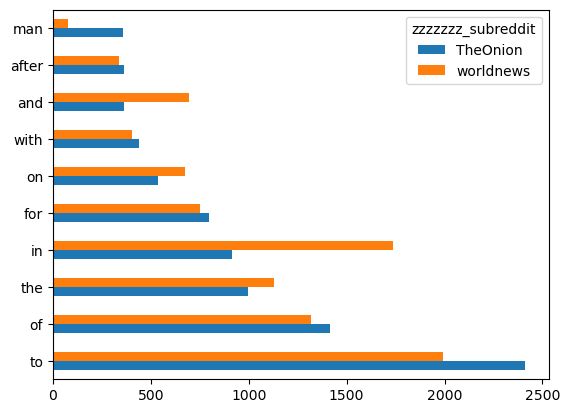

In [65]:
X_cvec.groupby('zzzzzzz_subreddit').sum().T.sort_values(by = 'TheOnion', ascending = False).head(10).plot.barh();

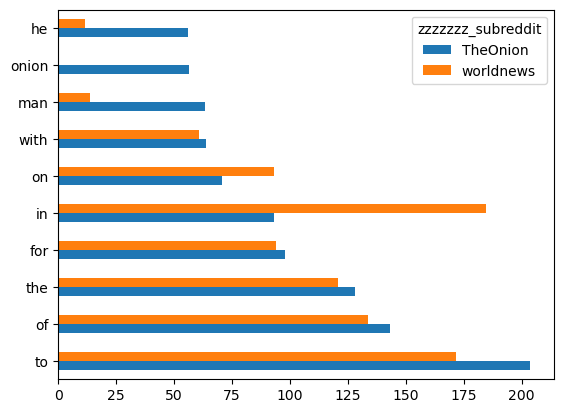

In [66]:
X_tvec['zzzzzzz_subreddit'] = reddit_df['subreddit']
X_tvec.head()
X_tvec.groupby('zzzzzzz_subreddit').sum().T.sort_values(by = 'TheOnion', ascending = False).head(10).plot.barh();

In [67]:
X_tvec.shape

(10367, 16794)

In [69]:
# The regex code here was created with the help of the following sources:
# Source:  https://stackoverflow.com/questions/18402416/regular-expression-to-match-a-word-or-its-prefix
# Source:  https://stackoverflow.com/questions/20462834/python-using-str-replace-with-a-wildcard
# Source:  https://regex101.com/
# Source:  https://stackoverflow.com/questions/5633533/regular-expression-for-matching-parentheses
# Source:  https://stackoverflow.com/questions/4007302/regex-how-to-match-an-optional-character
# Source:  https://www.regular-expressions.info/optional.html
# Source:  https://stackoverflow.com/questions/9655164/regex-ignore-case-sensitivity
# Source:  https://stackoverflow.com/questions/34583904/javascript-regex-ignore-case-for-specific-capture-group
# Source:  https://stackoverflow.com/questions/7548787/regex-for-and-not-operation


'''
The regex expression below will (in order or characters left to right):
- outer () - says to match all inside the parentheses
- /{0,1}r{0,1}/{0,1} - find a string with or without each of  /, r, and /
- [wW]orld[nN]ews - find worldnew optionally capitalized
- ( Live Thread: )? - it may have this text after it, if so find it, if not, don't
- | either or
- outer () - says to match all inside the parenthese
- \( - backslash tells it to treat left parenthesis as character
- Thread # - where it says 'Thread #'
- \d{1,} - \d any digit, {1,} at least one character long
- \) - backslash tells it to treat right parenthesis as character
'''

# Create the regex string
regex_string = '(/{0,1}r{0,1}/{0,1}[wW]orld[nN]ews( Live Thread: )?)|( \(Thread #\d{1,}\))'

# Find everthing matching that string and replcae with nothing
wldnws['title'] = wldnws['title'].apply(lambda post: re.sub(regex_string,'',post))

In [76]:
wordy = pd.DataFrame(cvec.get_feature_names_out(), columns= ['words'])
wordy['lang_dict'] = cvec_word_lang
wordy['lang'] = wordy['lang_dict'].apply(lambda x: x['language'])
wordy['score'] = wordy['lang_dict'].apply(lambda x: x['score'])
wordy

NameError: name 'cvec_word_lang' is not defined

In [ ]:
wordy['lang'].value_counts(ascending = False)

In [ ]:
wordy[wordy['lang']=='it']

In [ ]:
what_ = pd.read_csv('../data/theonion_1682378516.csv')

# Create the regex string
regex_string = '(/{0,1}r{0,1}/{0,1}[wW]orld[nN]ews( Live Thread: )?)|( \(Thread #\d{1,}\))'

print(what_[what_['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0].shape)
what_[what_['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0].head()